In [1132]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow import keras

import scipy.stats as stats

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.2f}".format

sns.set_theme(style="darkgrid")
cm = px.colors.sequential.Bluered

warnings.filterwarnings("ignore")

In [1133]:
# import sys

# sys.path.insert(1, '/kaggle/input/mymodules')

import my_module

In [1134]:
# PATH = '/kaggle/input/house-prices-advanced-regression-techniques/'
PATH = ""

train = pd.read_csv(f"{PATH}train.csv")
train.drop(["Id"], axis=1, inplace=True)

test = pd.read_csv(f"{PATH}test.csv")
test_ID = test["Id"]

test.drop(["Id"], axis=1, inplace=True)

df = pd.concat([train, test], ignore_index=True)

df.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2914,160,RM,21.00,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,160,RM,21.00,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,20,RL,160.00,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,85,RL,62.00,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN
2918,60,RL,74.00,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,NaN


<a id='1'> </a>

# 1. EDA


Let's delete all columns with a lot of nan values


In [1135]:
df = my_module.delete_nan_column(df, 0.25)

In [1136]:
df["Train_test"] = df["SalePrice"].isnull().apply(lambda x: "Test" if x else "Train")

<a id='1.1'> </a>

## 1.1 Numeric columns


In [1137]:
px.imshow(df.corr(), color_continuous_scale=cm, width=1000, height=1000)

First of all, I'm going to work with the features which are highly correlated with SalePrice.

Some of these features are correlated with each other, so I'm going to keep one of them and drop the other. For instance:

- YearBuilt and GarageYrBlt
- GarageArea and GarageCars


In [1138]:
numeric_features = my_module.get_type_features(df, ["int64", "float64"])

df_corr_sorted = (
    df[numeric_features].corr().sort_values(by=["SalePrice"])[["SalePrice"]].T
)

px.imshow(df_corr_sorted, color_continuous_scale=cm)

Let's examine ditributions and try to find obvious outliers


In [1139]:
features = my_module.get_corr_features(df[numeric_features].corr()["SalePrice"], 0.25)
features

['LotFrontage',
 'LotArea',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'FullBath',
 'HalfBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'SalePrice']

In [1140]:
# sns.pairplot(df[features + ["Train_test"]], diag_kind="kde", hue="Train_test")

There is a significant outlier in the top-right corner. What else is important, that these features are skewed, so I'm going to transform it later to make it more normal.


In [1141]:
df[df["1stFlrSF"] > 4500][features]

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice
1298,313.00,63887,10,2008,2008,796.00,5644.00,6110.00,4692,950,...,2,1,12,3,2008.00,2.00,1418.00,214,292,160000.00
2549,128.00,39290,10,2008,2009,1224.00,4010.00,5095.00,5095,0,...,2,1,15,2,2008.00,3.00,1154.00,546,484,NaN


1298 is the one. All positive correlated features are quite high, but the price is relatively low. I'll just delete it.


In [1142]:
df.drop([1298], inplace=True)

<a></a>

### SalePrice


In [1143]:
px.histogram(df, x="SalePrice").show()

In [1144]:
df.loc[df["SalePrice"] > 480000, "SalePrice"] = 480000

In [1145]:
px.histogram(df, x="SalePrice")

<a> </a>

### YearBuilt/YearRemodAdd


I combined YearBuilt and YearRemodAdd in a column


In [1146]:
df["YearBuilt/Remod"] = df["YearBuilt"].copy()
df.loc[df["YearBuilt"] > 1950, "YearBuilt/Remod"] = df.loc[
    df["YearBuilt"] > 1950, "YearRemodAdd"
]

In [1147]:
px.histogram(df, x="YearBuilt/Remod", color="Train_test")

In [1148]:
df.loc[df["YearBuilt/Remod"] < 1895, "YearBuilt/Remod"] = 1895
df.drop(["YearBuilt", "YearRemodAdd"], axis=1, inplace=True)
features.remove("YearBuilt")
features.remove("YearRemodAdd")
features.insert(0, "YearBuilt/Remod")

<a> </a>

### GarageArea/GarageCars


In [1149]:
df[["GarageArea", "GarageCars"]].corr()

,GarageArea,GarageCars
GarageArea,1.00,0.89
GarageCars,0.89,1.00


In [1150]:
df[df["GarageCars"] == 0]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Train_test,YearBuilt/Remod
39,90,RL,65.00,6040,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,6,2008,WD,AdjLand,82000.00,Train,1955
48,190,RM,33.00,4456,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,6,2009,New,Partial,113000.00,Train,1920
78,90,RL,72.00,10778,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,4,2010,WD,Normal,136500.00,Train,1968
88,50,C (all),105.00,8470,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,10,2009,ConLD,Abnorml,85000.00,Train,1915
89,20,RL,60.00,8070,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,8,2007,WD,Normal,123600.00,Train,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2893,50,C (all),60.00,8520,Grvl,Reg,Bnk,AllPub,Inside,Gtl,...,0,0,0,4,2006,WD,Normal,NaN,Test,1916
2909,180,RM,21.00,1470,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,4,2006,WD,Normal,NaN,Test,1970
2913,160,RM,21.00,1526,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,6,2006,WD,Normal,NaN,Test,1970
2914,160,RM,21.00,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,6,2006,WD,Normal,NaN,Test,1970


GarageArea looks more informative, so I delete GarageCars


In [1151]:
df.drop(["GarageCars"], axis=1, inplace=True)
features.remove("GarageCars")

In [1152]:
px.histogram(df, x="GarageArea", color="Train_test")

Some clipping


In [1153]:
df.loc[df["GarageArea"] > 950, "GarageArea"] = 950

<a> </a>

### TotalBsmtSF


In [1154]:
px.histogram(df, x="TotalBsmtSF", color="Train_test")

In [1155]:
df.loc[df["TotalBsmtSF"] > 2250, "TotalBsmtSF"] = 2250

<a id='1.1.2'> </a>

### GrLivArea


In [1156]:
px.histogram(df, x="GrLivArea", color="Train_test")

In [1157]:
df.loc[df["GrLivArea"] > 2800, "GrLivArea"] = 2800

<a> </a>

### 1stFlrSF


In [1158]:
px.histogram(df, x="1stFlrSF", color="Train_test")

In [1159]:
df.loc[df["1stFlrSF"] > 2500, "1stFlrSF"] = 2500

<a> </a>

### FullBath


In [1160]:
px.histogram(df, x="FullBath", color="Train_test")

In [1161]:
df.loc[df["FullBath"] == 0, "FullBath"] = 1
df.loc[df["FullBath"] == 4, "FullBath"] = 3
px.histogram(df, x="FullBath", color="Train_test")

<a> </a>

### TotRmsAbvGrd


In [1162]:
df[["TotRmsAbvGrd", "GrLivArea"]].corr()

,TotRmsAbvGrd,GrLivArea
TotRmsAbvGrd,1.00,0.81
GrLivArea,0.81,1.00


In [1163]:
df.drop(["TotRmsAbvGrd"], axis=1, inplace=True)
features.remove("TotRmsAbvGrd")

<a id="2"></a>

# 2. Preprocessing


In [1164]:
features

['YearBuilt/Remod',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'MasVnrArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'FullBath',
 'HalfBath',
 'Fireplaces',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'SalePrice']

Imput median values in the numeric columns


In [1165]:
df_final = df[features].copy(deep=True)

In [1166]:
for col in features[:-1]:
    imp = SimpleImputer(missing_values=np.nan, strategy="median")
    df_final[[col]] = imp.fit_transform(df_final[[col]])

<a> </a>

### Transformation of data


In [1167]:
power = preprocessing.PowerTransformer()
for_tranfrom = ["TotalBsmtSF", "1stFlrSF", "GrLivArea", "GarageArea"]
df_final[for_tranfrom] = power.fit_transform(df_final[for_tranfrom])
df_final.head()

,YearBuilt/Remod,LotFrontage,LotArea,OverallQual,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,Fireplaces,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice
0,2003.00,65.00,8450.00,7.00,196.00,706.00,-0.41,-0.78,854.00,0.57,2.00,1.00,0.00,2003.00,0.40,0.00,61.00,208500.00
1,1976.00,80.00,9600.00,6.00,0.00,978.00,0.54,0.43,0.00,-0.39,2.00,0.00,1.00,1976.00,-0.00,298.00,0.00,181500.00
2,2002.00,68.00,11250.00,7.00,162.00,486.00,-0.26,-0.56,866.00,0.71,2.00,1.00,1.00,2001.00,0.67,0.00,42.00,223500.00
3,1915.00,60.00,9550.00,7.00,0.00,216.00,-0.66,-0.42,756.00,0.58,1.00,0.00,1.00,1998.00,0.82,0.00,35.00,140000.00
4,2000.00,84.00,14260.00,8.00,350.00,655.00,0.27,0.12,1053.00,1.39,2.00,1.00,1.00,2000.00,1.65,192.00,84.00,250000.00


Scalling


In [1168]:
scaler = preprocessing.StandardScaler()
df_final[df_final.columns[:-1]] = scaler.fit_transform(df_final.iloc[:, :-1])
df_final.head()

,YearBuilt/Remod,LotFrontage,LotArea,OverallQual,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,Fireplaces,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice
0,0.92,-0.19,-0.22,0.65,0.53,0.60,-0.41,-0.78,1.21,0.57,0.80,1.23,-0.93,1.00,0.40,-0.74,0.20,208500.00
1,0.05,0.53,-0.07,-0.06,-0.57,1.21,0.54,0.43,-0.78,-0.39,0.80,-0.76,0.63,-0.09,-0.00,1.62,-0.70,181500.00
2,0.89,-0.05,0.14,0.65,0.34,0.10,-0.26,-0.56,1.24,0.71,0.80,1.23,0.63,0.92,0.67,-0.74,-0.08,223500.00
3,-1.92,-0.43,-0.08,0.65,-0.57,-0.50,-0.66,-0.42,0.98,0.58,-1.06,-0.76,0.63,0.80,0.82,-0.74,-0.18,140000.00
4,0.83,0.72,0.53,1.36,1.39,0.48,0.27,0.12,1.67,1.39,0.80,1.23,0.63,0.88,1.65,0.78,0.54,250000.00


Final view


In [1169]:
# sns.pairplot(df_final, diag_kind="kde")

<a id="3"></a>

# 3. Model development


<a id='3.1'> </a>

## 3.1 Baseline


In [1170]:
df_final.columns

Index(['YearBuilt/Remod', 'LotFrontage', 'LotArea', 'OverallQual',
       'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'FullBath', 'HalfBath', 'Fireplaces', 'GarageYrBlt',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice'],
      dtype='object')

In [1181]:
for_prediction = [
    "OverallQual",
    "TotalBsmtSF",
    "GrLivArea",
    "GarageArea",
    "1stFlrSF",
    "YearBuilt/Remod",
    "FullBath",
    "SalePrice",
]

df_features = df_final[for_prediction]

In [1182]:
rng = 0
x = df_features[~df_features["SalePrice"].isna()][df_features.columns[:-1]]
y = df_features[~df_features["SalePrice"].isna()]["SalePrice"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=rng
)

In [1183]:
my_module.check_distribution(x_train, x_test)

,OverallQual,TotalBsmtSF,GrLivArea,GarageArea,1stFlrSF,YearBuilt/Remod,FullBath
0,True,True,True,True,True,True,True


As we predict a continues value, we can use a mean value as a baseline


In [1184]:
mean_price = np.full(len(x), np.mean(y))
my_module.print_evaluate_regression(mean_price, y)

MSE: 5692225017.019124
RMSLE: 0.1623656493871091
______


<a id='3.2'></a>

## 3.2 Simple NN model


In [1185]:
x_train.head()

,OverallQual,TotalBsmtSF,GrLivArea,GarageArea,1stFlrSF,YearBuilt/Remod,FullBath
92,-0.77,-0.37,-1.21,-0.13,-0.41,-1.72,-1.06
838,-0.77,0.16,-0.81,-0.51,-0.00,1.02,-1.06
360,-0.06,-0.34,-1.37,0.04,-0.59,0.12,-1.06
665,1.36,0.86,0.97,0.20,0.88,0.83,0.80
40,-0.06,0.14,-0.24,-0.09,0.58,-0.30,0.80


Final training loss: 935151488.0
Final Validation loss: 675751104.0
10/10 [==============================] - 0s 1000us/step
MSE: 745894190.4841384
RMSLE: 0.022890254253797242
______


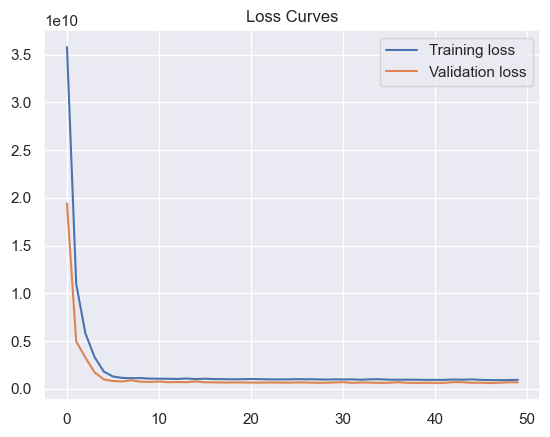

In [1186]:
learning_rate = 0.5
epochs = 50
batch_size = 50

model = None

# Define model
model = keras.Sequential()
model.add(
    keras.layers.Dense(
        units=x_train.shape[1],
        activation="relu",
        input_dim=x_train.shape[1],
        kernel_regularizer=tf.keras.regularizers.l2(l2=0.01),
    ),
)
model.add(
    keras.layers.Dense(
        units=x_train.shape[1],
        activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(l2=0.01),
    )
)

model.add(keras.layers.Dense(units=1, activation="linear"))
# Specify the optimizer using the TF API to specify the learning rate
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    loss="mse",
)

# Train the model
trainHistory = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=0,
)
# Plot
my_module.showRegressionResults(trainHistory)


my_module.print_evaluate_regression(model.predict(x_test), y_test)

In [1187]:
import logging

logname = "model_results.log"

logging.basicConfig(
    filename=logname,
    filemode="a",
    format="%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s",
    datefmt="%H:%M:%S",
    level=logging.INFO,
)

logger = logging.getLogger("my_logger")

logging.info("Logging set")
logging.info(model.to_json())
logging.info(features[:-1])
my_module.log_evaluate_regression(model.predict(x_test), y_test)
logging.shutdown()

10/10 [==============================] - 0s 1000us/step


In [1188]:
x_sub = df_final.loc[df["SalePrice"].isna()][for_prediction[:-1]]
pred = model.predict(x_sub, batch_size=batch_size).flatten()

sub = pd.DataFrame({"Id": test_ID, "SalePrice": pred})
my_module.test_nulls(sub)
sub.to_csv("submission.csv", index=False)

30/30 [==============================] - 0s 1ms/step
Engineered features do not contain nulls.
